In [129]:
import pandas as pd
import numpy as np
import yfinance as fy
from datetime import date
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [130]:
symbol = 'AMZN'
start_date = '2010-01-01'
end_date = date.today()

In [131]:
data = fy.download(symbol,start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [189]:
data.shape

(3366, 6)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3334 entries, 2010-01-04 to 2023-03-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3334 non-null   float64
 1   High       3334 non-null   float64
 2   Low        3334 non-null   float64
 3   Close      3334 non-null   float64
 4   Adj Close  3334 non-null   float64
 5   Volume     3334 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 182.3 KB


In [33]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3.334000e+03
mean,59.638136,60.330367,58.871561,59.614072,59.614072,8.796030e+07
std,53.866679,54.517237,53.140183,53.819293,53.819293,5.274048e+07
min,5.296500,5.564500,5.290000,5.430500,5.430500,1.762600e+07
25%,13.453875,13.575875,13.272625,13.443500,13.443500,5.608835e+07
50%,37.885500,38.099501,37.561251,37.839500,37.839500,7.424600e+07
75%,94.054998,95.097498,93.000000,94.153498,94.153498,1.030715e+08
max,187.199997,188.654007,184.839493,186.570496,186.570496,8.484220e+08


In [132]:
close_data = data.reset_index()['Close']

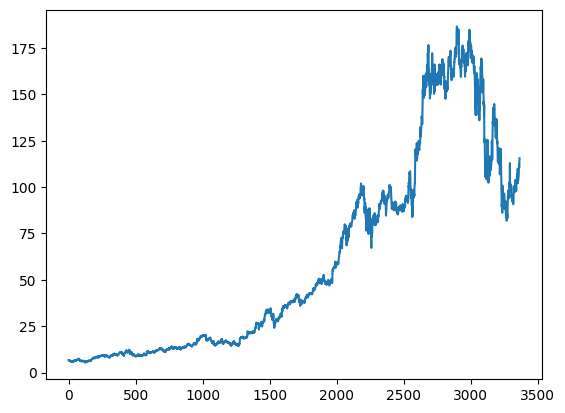

In [133]:
plt.plot(close_data)

In [201]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(close_data).reshape(-1, 1))

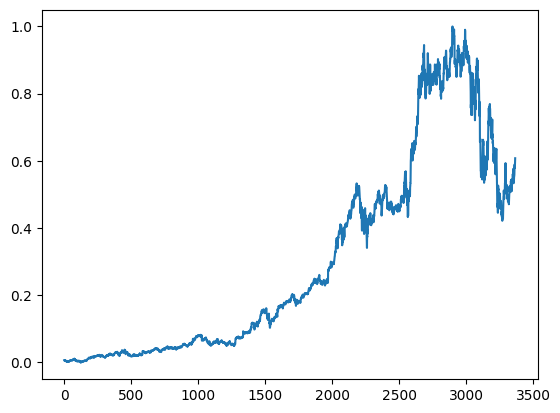

In [202]:
plt.plot(scaled_data)

In [228]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:] 

In [229]:
def create_dataset(data, time_steps=1):
    X,Y = [], []
    for i in range (len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        Y.append(data[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 50
X_train, Y_train = create_dataset(train_data,time_steps)
X_test, Y_test = create_dataset(test_data,time_steps)

In [230]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)

In [231]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer="adam", loss="mean_squared_error")

In [232]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 50, 50)            10400     
                                                                 
 lstm_25 (LSTM)              (None, 50, 50)            20200     
                                                                 
 lstm_26 (LSTM)              (None, 50)                20200     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [233]:
model.fit(X_train, Y_train, validation_data=(X_test,Y_test),epochs=100, batch_size=32)

Epoch 1/100
83/83 [==============================] - 8s 51ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 2/100
83/83 [==============================] - 3s 41ms/step - loss: 3.5245e-04 - val_loss: 0.0051
Epoch 3/100
83/83 [==============================] - 3s 42ms/step - loss: 3.2023e-04 - val_loss: 0.0041
Epoch 4/100
83/83 [==============================] - 3s 42ms/step - loss: 2.9272e-04 - val_loss: 0.0042
Epoch 5/100
83/83 [==============================] - 3s 41ms/step - loss: 3.3725e-04 - val_loss: 0.0027
Epoch 6/100
83/83 [==============================] - 3s 41ms/step - loss: 2.9737e-04 - val_loss: 0.0057
Epoch 7/100
83/83 [==============================] - 3s 42ms/step - loss: 2.8496e-04 - val_loss: 0.0067
Epoch 8/100
83/83 [==============================] - 4s 43ms/step - loss: 2.3170e-04 - val_loss: 0.0016
Epoch 9/100
83/83 [==============================] - 4s 43ms/step - loss: 2.0427e-04 - val_loss: 0.0016
Epoch 10/100
83/83 [==============================] - 4s 44ms/step -

In [209]:
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [210]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

30/30 [==============================] - 0s 15ms/step


In [211]:
train_predictions = scaler.inverse_transform(train_predictions)
Y_train = scaler.inverse_transform([Y_train])
test_predictions = scaler.inverse_transform(test_predictions)
Y_test = scaler.inverse_transform([Y_test])

In [212]:
train_size

2356

In [213]:
Y_train.size

2306

In [214]:
train_size+time_steps

2406

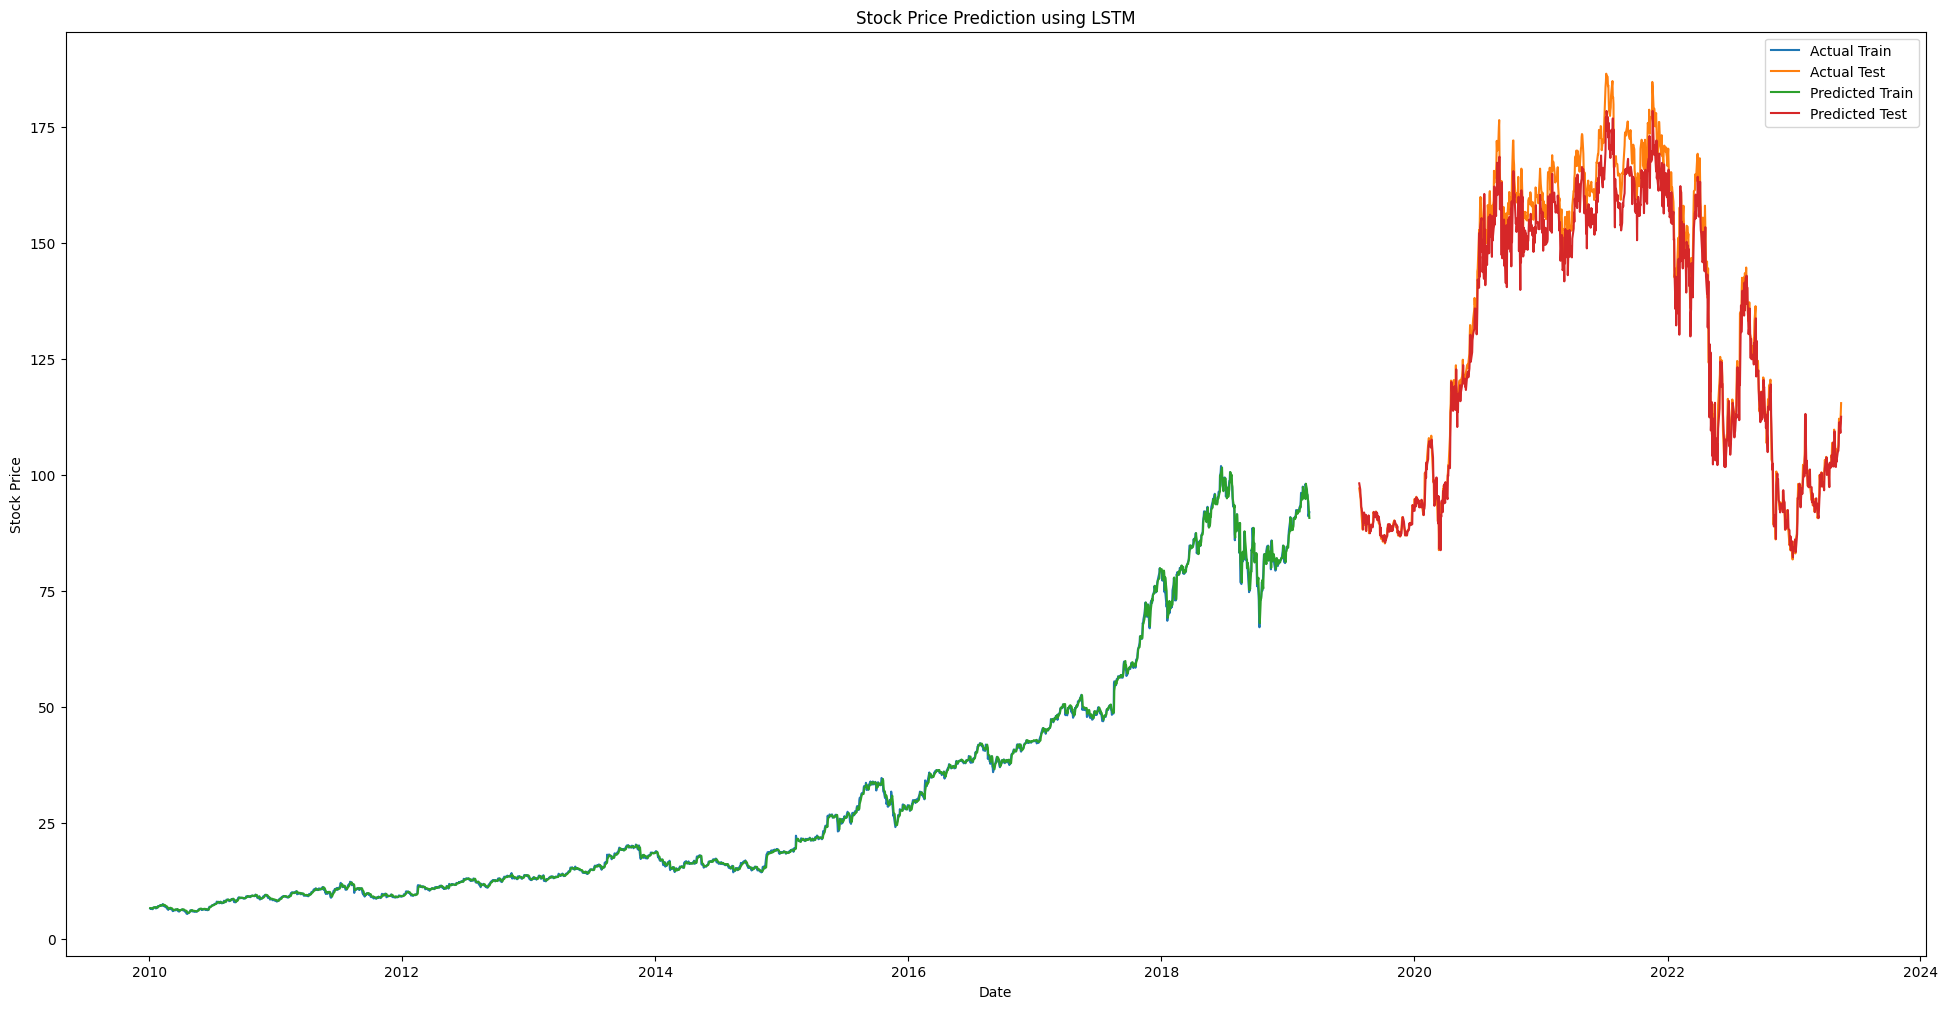

In [227]:
plt.figure(figsize=(24, 12))
plt.plot(data.index[:train_size-time_steps], Y_train.flatten(), label="Actual Train")
plt.plot(data.index[train_size+time_steps:], Y_test.flatten(), label="Actual Test")
plt.plot(data.index[:train_size-time_steps], train_predictions.flatten(), label="Predicted Train")
plt.plot(data.index[train_size+time_steps:], test_predictions.flatten(), label="Predicted Test")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction using LSTM")
plt.legend()
plt.show()
